# Imports

In [2]:
import numpy as np                     # Packages for Data Analysis
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags

import matplotlib.pyplot as plt       # Packages for making plots
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

import braingeneers                  # Braigneneers packages for analysis
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
import random

# Data

In [5]:
import pickle
from human_hip.spike_data import plot_functional_connectivity_map

with open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', "rb") as my_file:
    sd = pickle.load(my_file)

# Helper functions

In [13]:
def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    """
    Output: Returns a list with values ""grey", "red", "blue" representing whether a neuron is a "broker", "sender" or "receiver" respectively
    Inputs:
        in_out_deg- A list of tuples, [(incoming,outgoing),....] , containing the number of in/out signals for each neuron.
        latency_thresh- A float between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
    """
    # Nodes with high fraction of outgoing edges labelled 'sender' - 'red'
    # Nodes with high fraction of incoming edges labelled 'receiver' - 'blue'
    # Nodes with no high fraction are labelled `broker` - 'grey'
    # Threshold is set to 0.2 - in Tal Sharf paper this is 0.8
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
        test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        # node_info[i] = (test1, test2)
        if test1 > latency_thresh:
            node_info[i] = 'red'
        if test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info # Returns a list of strings 

def plot_functional_connectivity_map( sd, latency_threshold=.1, show_sttc=True,  sttc_threshold=.1):
    """
    Output: plots the functional connectivity map, displayin "sender" and ""receiver" neurons in the neural circuit
    Inputs:
        sd (SpikeData object)- the standard data format for braingeneers
        latency_threshold (float)- Between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
        show_sttc (boolean)- If True, the spike time tiling connections between neurons are also plotted
        sttc_threshold (float)- Between 0-1. The strength a spike time tiling correlation must be above in order to be plotted
    """
    # Plot functional connectivity map
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(8,6))
    plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)
    plt.title("Neuron layout")
    plt.xlabel('um')
    plt.ylabel('um')

    # Plot spike time tiling connections between neurons
    if show_sttc:
        sttc = sd.spike_time_tilings()
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue
                if sttc[i,j] < sttc_threshold : continue
                ix,iy = sd.neuron_data[0][i]['position']
                jx,jy = sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                # Plot line between the points with linewidth and opacity
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)

    plt.show()

# Method

calculating all latencies...
making plot


/tmp/ipykernel_38503/1387845.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_38503/1387845.py:111: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data[0][i]['position']
/tmp/ipykernel_38503/1387845.py:112: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data[0][j]['position']


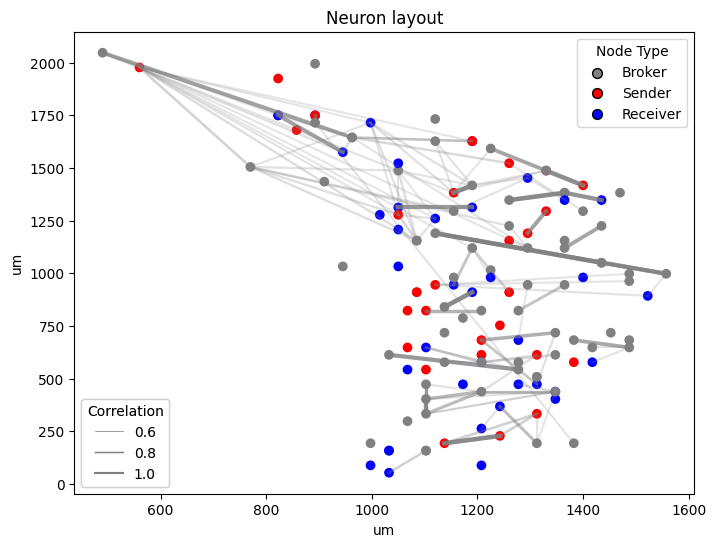

In [14]:
plot_functional_connectivity_map(sd, latency_threshold=.1, show_sttc=True,  sttc_threshold=.1)